### Reproduce the CIFAR10 experiment of the Layer-wise invertible model

In [1]:
import numpy as np
import torch
from torch import nn
import pandas as pd

from revunet.logmem import *
import matplotlib.pyplot as plt
plt.style.use("dark_background")
%matplotlib inline

import sys
sys.path.append("./cifar10-fast/")
from helpers import *
from layers import *
from models import *

import torchvision

/home/tristan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [2]:
class IFlatXD(nn.Module):
    def __init__(self, infeatures=32, invert=False, 
                 pools  = ["depth", "depth", "depth"],
                 layers = [2, 3, 4, 3], w=0.125,
                 negative_slope=0.01, bn_ieps=0.1,
                 inchannels=1):
        """
        """
        super().__init__()
        features = compute_features(infeatures, pools)
        
        prep   = iconv_bn_xd(inchannels, features[0], invert=invert, conv_invert=False, negative_slope=negative_slope, bn_ieps=bn_ieps)
        layer  = iconv_bn_xd_seq(features[0], layers[0]-1, invert=invert, negative_slope=negative_slope, bn_ieps=bn_ieps)

        modules = [prep, layer]
        for i in range(1, len(layers)):
            pool  = ShapePool2DXD(2, pools[i-1])
            layer = iconv_bn_xd_seq(features[i], layers[i], invert=invert, negative_slope=negative_slope, bn_ieps=bn_ieps)
            modules.extend([pool, layer])
            
        self.features = nn.Sequential(*modules)
        self.pool   = nn.MaxPool3d((compute_pooling(pools), 2**(5-len(pools)), 2**(5-len(pools))))
        self.linear = nn.Linear(features[-1], 10, bias=False)
        self.w = w
        
    def forward(self, x):
        """
        """
        x = x[:,:,None,:,:]
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.linear(x)
        return x*self.w

In [3]:
dataset = cifar10(root='./data/cifar10')
train_set = list(zip(transpose(normalise(pad(dataset['train']['data'], 4))), dataset['train']['labels']))
test_set = list(zip(transpose(normalise(dataset['test']['data'])), dataset['test']['labels']))

device = 3
epochs = 40
lr_schedule = PiecewiseLinear([0, 5, epochs], [0, 0.4, 0])
batch_size = 512
transforms = [Crop(32, 32), FlipLR(), Cutout(8, 8)]
N_runs = 1

train_batches = Batches(Transform(train_set, transforms), batch_size, shuffle=True, 
                        set_random_choices=True, drop_last=True, device=device)
test_batches  = Batches(test_set, batch_size, shuffle=False, drop_last=False, device=device)
lr = lambda step: lr_schedule(step/len(train_batches))/batch_size

Files already downloaded and verified
Files already downloaded and verified


# Experiments

### A. Depth

In [6]:
infeatures_ = {False:32, True:48}
pools = ["channel", "channel"]
summaries = {}
ieps = 0.1
negative_slope = 0.2
nlayers = [0, 1, 1]

for invert in [False, True]:
    infeatures = infeatures_[invert]
    nlayers = [0,1,1]
    for i in range(10):
        nlayers[i%len(nlayers)]+=1
        model = IFlatXD(infeatures=infeatures, invert=True, layers=nlayers, pools=pools,
                       negative_slope=negative_slope, bn_ieps=ieps, inchannels=3).cuda(device)
        mods = list(filter(lambda x:type(x) in [ILeakyReLU, IBatchNorm3d], model.modules()))
        
        for mod in mods:
            mod.set_invert(invert)
            
        opt = SGD(trainable_params(model), lr=lr, momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
        summaries[(invert, i)]=train(model, opt, train_batches, test_batches, epochs, loggers=(TableLogger(),))

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0800       7.8495       1.9987       0.2769      24.8286       1.6702       0.4126      32.6781
           2       0.1600       7.7238       1.5009       0.4691       0.5563       1.2647       0.5538      40.9582
           3       0.2400       7.7503       1.2684       0.5523       0.5569       1.1293       0.5943      49.2654
           4       0.3200       7.7821       1.1183       0.6074       0.5583       1.0412       0.6303      57.6057
           5       0.4000       7.8142       1.0099       0.6470       0.5618       0.9274       0.6767      65.9817
           6       0.3886       7.8364       0.9221       0.6808       0.5589       0.8203       0.7195      74.3769
           7       0.3771       7.8149       0.8517       0.7092       0.5599       0.8314       0.7048      82.7517
           8       0.3657       7.8424       0.8116       0.7241

In [31]:
X  = [k+(v["test acc"],) for k,v in summaries.items()]
df = pd.DataFrame(X, columns=["invert", "N layer", "acc"])

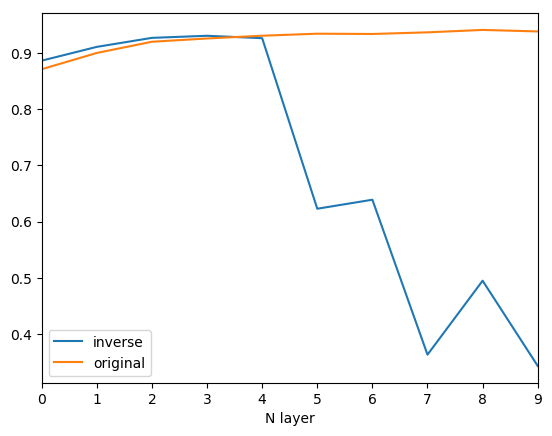

In [32]:
fig, ax = plt.subplots(1,1)

df[df.invert==True].plot(y="acc", x="N layer", ax=ax, label="inverse")
df[df.invert==False].plot(y="acc", x="N layer", ax=ax, label="original")

fig.savefig("figures/accuracy_flat_errors_layers")

###  B. Leaky ReLU slope

In [ ]:
infeatures = 32
pools = ["channel", "channel"]
summaries_2 = {}
ieps = 0.1
nlayers = [1,2,2]

for invert in [False, True]:
    for negative_slope in [0.001, 0.002, 0.005, 0.01, 
                           0.02, .05, .1, .2, .5, .75]:
        model = IFlatXD(infeatures=infeatures, invert=True, layers=nlayers, pools=pools,
                       negative_slope=negative_slope, bn_ieps=ieps, inchannels=3).cuda(device)
        mods = list(filter(lambda x:type(x) in [ILeakyReLU, IBatchNorm3d], model.modules()))
        
        for mod in mods:
            mod.set_invert(invert)
            
        opt = SGD(trainable_params(model), lr=lr, momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
        summaries_2[(invert, negative_slope)]=train(model, opt, train_batches, test_batches, epochs, loggers=(TableLogger(),))

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0800      14.2800       1.8723       0.3229       0.9704       1.4562       0.4749      15.2504
           2       0.1600      14.3733       1.2926       0.5372       0.9738       1.2971       0.5502      30.5975
           3       0.2400      14.4333       1.0107       0.6428       0.9787       1.0165       0.6497      46.0095
           4       0.3200      14.4875       0.8219       0.7150       0.9798       0.7195       0.7539      61.4767
           5       0.4000      14.5174       0.7172       0.7516       0.9794       0.7764       0.7253      76.9735
           6       0.3886      14.5364       0.6406       0.7810       0.9838       0.6847       0.7727      92.4937
           7       0.3771      14.5572       0.5829       0.8010       0.9824       0.6268       0.7906     108.0333
           8       0.3657      14.5520       0.5484       0.8121

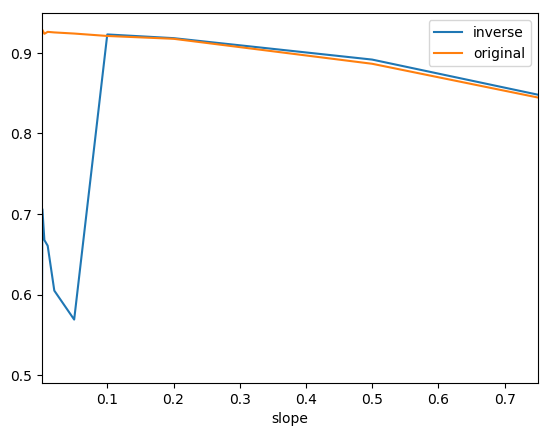

In [29]:
X  = [k+(v["test acc"],) for k,v in summaries_2.items()]
df = pd.DataFrame(X, columns=["invert", "slope", "acc"])

fig, ax = plt.subplots(1,1)

df[df.invert==True].plot(y="acc", x="slope", ax=ax, label="inverse")
df[df.invert==False].plot(y="acc", x="slope", ax=ax, label="original")

fig.savefig("figures/accuracy_flat_errors_slope")